# Data exploration and cleaning

In [1]:
import numpy as np
import pandas as pd
import seaborn
import os

from matplotlib import pyplot as plt
from numpy import log1p

## Import data

### for google colab 

<a href="https://colab.research.google.com/github/Nick1288/TennisStrokePrediction/blob/main/TennisStrokePrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
uploaded = files.upload()
data = pd.read_csv("charting-m-points")

print(data.columns)

### for jupter Notebook

In [2]:
os.chdir('c:/Users/nicho/Downloads')
print(os.getcwd())

data = pd.read_csv('charting-m-points.csv', encoding='latin1')

print(data.columns)

c:\Users\nicho\Downloads


C:\Users\nicho\AppData\Local\Temp\ipykernel_52212\4243856806.py:4: DtypeWarning: Columns (7,12,24,25,26,31,32,33,34,35,45,51) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('charting-m-points.csv', encoding='latin1')


Index(['match_id', 'Pt', 'Set1', 'Set2', 'Gm1', 'Gm2', 'Pts', 'Gm#', 'TbSet',
       'TB?', 'TBpt', 'Svr', 'Ret', 'Serving', '1st', '2nd', 'Notes',
       '1stNoLet', '2ndNoLet', '1stSV', '2ndSV', '1stNoSV', '2ndNoSV', '1stIn',
       '2ndIn', 'isRally1st', 'isRally2nd', 'Sv1', 'Sv2', 'Rally', 'isAce',
       'isUnret', 'isRallyWinner', 'isForced', 'isUnforced', 'isDouble',
       'rallyNoSpec', 'rallyNoError', 'rallyNoDirection', 'rallyLen',
       'PtWinner', 'isSvrWinner', 'PtsAfter', 'GmW', 'Gm1.1', 'Gm2.1', 'SetW',
       'Set1.1', 'Set2.1', 'RevTB', 'TBrev', 'rallyCount'],
      dtype='object')


## Data cleaning

In [3]:
dropped_features = ["TbSet", "TBpt", "1st", "2nd", "Notes", "1stNoLet", "2ndNoLet", "1stSV", "2ndSV", "1stNoSV", "2ndNoSV", "1stIn", "2ndIn", "isRally1st", "isRally2nd", "Rally", "rallyNoSpec", "rallyNoDirection", "PtWinner", "isSvrWinner", "PtsAfter", 'GmW', 'Gm1.1', 'Gm2.1', 'SetW', 'Set1.1', 'Set2.1', "RevTB", "TBrev", "rallyCount"]

kept_features = ["Pt", "Set1", "Set2", "Gm1", "Gm2", "Pts", "Gm#", "TB?", "rallyLen"]

processing_features = [ "match_id", "Svr", "Ret", "Serving","Sv1", "Sv2","isAce", "isUnret", "isRallyWinner", "isForced", "isUnforced", "isDouble", "rallyNoError"]


data = data.drop(columns=dropped_features, errors='ignore')

# Split the data into two datasets
kept_features_data = data[kept_features].copy()
processing_features_data = data[processing_features].copy()

print("Kept Features Types:")
print(kept_features_data.dtypes)

print("\nProcessed Features Types:")
print(processing_features_data.dtypes)


Kept Features Types:
Pt            int64
Set1          int64
Set2          int64
Gm1           int64
Gm2         float64
Pts          object
Gm#          object
TB?         float64
rallyLen      int64
dtype: object

Processed Features Types:
match_id         object
Svr               int64
Ret              object
Serving          object
Sv1              object
Sv2              object
isAce              bool
isUnret          object
isRallyWinner    object
isForced         object
isUnforced       object
isDouble         object
rallyNoError     object
dtype: object


In [4]:
print("\nMissing values:")
print(data.isnull().sum())


Missing values:
match_id              0
Pt                    0
Set1                  0
Set2                  0
Gm1                   0
Gm2                   1
Pts                   0
Gm#                   1
TB?                  75
Svr                   0
Ret                   0
Serving             946
Sv1                   0
Sv2              205088
isAce                 0
isUnret              10
isRallyWinner        10
isForced             10
isUnforced            0
isDouble              0
rallyNoError      44059
rallyLen              0
dtype: int64


# Process deduced features and compount features

In [5]:
def filter_data_by_player(data, target_player):
    """
    Filters the data for rows where the target player is playing.

    Parameters:
    data (pd.DataFrame): The input dataset.
    target_player (str): The name of the target player.

    Returns:
    pd.DataFrame: Filtered dataset containing only rows where the target player is playing.
    """
    # Select "match_id" where target player is playing
    selected_match_ids = data.loc[data['Serving'] == target_player, 'match_id'].unique()

    # Filter rows in data where "match_id" is in the selected match_ids
    filtered_data = data[data['match_id'].isin(selected_match_ids)]
    
    return filtered_data

#In processing_data create "Svr" : 1 if the target player is serving, 0 if the target player is receiving
def create_svr_column(data, target_player): 
    """
    Creates a new column "Svr" in the dataset indicating if the target player is serving.

    Parameters:
    data (pd.DataFrame): The input dataset.
    target_player (str): The name of the target player.

    Returns:
    pd.DataFrame: Updated dataset with the new "Svr" column.
    """
    data['Svr'] = np.where(data['Serving'] == target_player, 1, 0)
    return data

In [7]:
# define shot types to be mapped for our unforced error and winners array
shot_types = [
    'f', 'b',  # groundstrokes
    'r', 's',  # slices
    'v', 'z',  # volleys
    'o', 'p',  # overheads
    'u', 'y',  # drop shots
    'l', 'm',  # lobs
    'h', 'i',  # half-volleys
    'j', 'k',  # swinging volleys
]

# generate combinations with directions 1, 2, 3
shot_vocab = {f"{shot}{n}": idx for idx, (shot, n) in enumerate(
    (s, i) for s in shot_types for i in [1, 2, 3]
)}



In [16]:
def process_rally_data(df, shot_vocab):
    """
    Processes rally data into 3-shot sequences with serve context and a 48-class label array.

    Parameters:
        df (pd.DataFrame): Dataframe containing at least these columns:
            'Sv1', 'Sv2', 'rallyNoSpec', 'isAce', 'isUnret', 'isRallyWinner',
            'isForced', 'isUnforced', 'isDouble', 'rallyNoError'
        shot_vocab (dict): Mapping of shot codes (e.g., 'f1', 'b2') to indices (0-47)

    Returns:
        pd.DataFrame: New dataframe with columns ['shot1', 'shot2', 'shot3', 'label_array']
    """
    sequence_data = []

    for _, row in df.iterrows():
        rally_tokens=[]
        isServe = row['Svr'] == 1
        rally = row['rallyNoError']

        if (pd.isna(rally) or len(rally)<2):
            continue

        if (len(rally)==2):
            rally_tokens = [rally]
        else:
            rally_tokens.append(rally[:3])    # return is 3 characters instead of 2
            rally_tokens.extend([rally[i:i+2] for i in range(3, len(rally)-1, 2)])

        # serve logic
        if not pd.isna(row['Sv1']):
            if not pd.isna(row['Sv2']):  # second serve used
                full_rally = [row['Sv1'], row['Sv2']] + rally_tokens
            else:  # first serve only
                full_rally = ['0', row['Sv1']] + rally_tokens
        else:
            continue  # skip if no valid serve found

        # Create 48-dim label array
        winner_array = np.zeros(48)
        unforced_array = np.zeros(48)

        if len(rally_tokens) > 0:
            final_shot = rally_tokens[-1]
            idx = shot_vocab.get(final_shot, None)

            if idx is not None:
                if row['isRallyWinner']:
                    winner_array[idx] += 1  # winner
                elif row['isUnforced']:
                    unforced_array[idx] += 1  # unforced error

        # Generate 3-shot sequences
        if (isServe):
            i = 1
            while i + 2 < len(full_rally):
                sequence_data.append({
                    'shot1': full_rally[i],
                    'shot2': full_rally[i + 1],
                    'shot3': full_rally[i + 2],
                    'winner_array': winner_array.copy(),
                    'unforced_array': unforced_array.copy(),
                })
                i += 2
        else:
            i = 0
            while i + 2 < len(full_rally):
                sequence_data.append({
                    'shot1': full_rally[i],
                    'shot2': full_rally[i+1],
                    'shot3': full_rally[i+2],
                    'winner_array': winner_array.copy(),
                    'unforced_array': unforced_array.copy(),
                })
                i += 2


    return pd.DataFrame(sequence_data)

### Acutual processing

In [30]:
processing_data = data.copy()
target_player = "RF"

# Test the filter_data_by_player function
processing_data = filter_data_by_player(processing_data, target_player)

# Print the number of unique match IDs selected
num_unique_matches = len(processing_data['match_id'].unique())
print(f"Number of Unique Matches Found: {num_unique_matches}")

# Print the number of rows selected
num_rows_selected = processing_data.shape[0]
print(f"Number of Rows Selected: {num_rows_selected}")

# Calculate and print the sum of rally lengths for all rows
if 'rallyLen' in processing_data.columns:
    rally_len_sum = processing_data['rallyLen'].sum()
    print(f"Sum of Rally Lengths: {rally_len_sum}")
else:
    print("Column 'rallyLen' not found in the dataset.")

# Test the create_svr_column function
processing_data = create_svr_column(processing_data, target_player)

Number of Unique Matches Found: 322
Number of Rows Selected: 55713
Sum of Rally Lengths: 200252


In [31]:
print(processing_data["rallyNoError"].head(5))

6980            f27f3
6981               s2
6982               f1
6983    b38f3b1f1f3s2
6984              NaN
Name: rallyNoError, dtype: object


In [32]:
sequence_data = process_rally_data(processing_data,shot_vocab=shot_vocab)

In [ ]:
sequence_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82257 entries, 0 to 82256
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   shot1           82257 non-null  object
 1   shot2           82257 non-null  object
 2   shot3           82257 non-null  object
 3   winner_array    82257 non-null  object
 4   unforced_array  82257 non-null  object
dtypes: object(5)
memory usage: 3.1+ MB


In [34]:
processed_data = pd.concat([processing_data,sequence_data], ignore_index=True)
processed_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151587 entries, 0 to 151586
Data columns (total 27 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   match_id        55713 non-null  object 
 1   Pt              55713 non-null  float64
 2   Set1            55713 non-null  float64
 3   Set2            55713 non-null  float64
 4   Gm1             55713 non-null  float64
 5   Gm2             55713 non-null  float64
 6   Pts             55713 non-null  object 
 7   Gm#             55713 non-null  object 
 8   TB?             55713 non-null  float64
 9   Svr             55713 non-null  float64
 10  Ret             55713 non-null  object 
 11  Serving         55713 non-null  object 
 12  Sv1             55713 non-null  object 
 13  Sv2             21023 non-null  object 
 14  isAce           55713 non-null  object 
 15  isUnret         55713 non-null  object 
 16  isRallyWinner   55713 non-null  object 
 17  isForced        55713 non-nul

In [35]:
processed_data = data.drop(columns=processing_features, errors='ignore')

print("\nMissing values:")
print(data.isnull().sum())


Missing values:
match_id              0
Pt                    0
Set1                  0
Set2                  0
Gm1                   0
Gm2                   0
Pts                   0
Gm#                   0
TB?                   0
Svr                   0
Ret                   0
Serving             946
Sv1                   0
Sv2              205086
isAce                 0
isUnret              10
isRallyWinner        10
isForced             10
isUnforced            0
isDouble              0
rallyNoError      44059
rallyLen              0
dtype: int64


In [11]:
data['TB?'].fillna(0, inplace=True)

# Remove rows where 'Gm2' or 'Gm#' have missing values
data.dropna(subset=['Gm2', 'Gm#'], inplace=True)

print("\nMissing values after handleing:")
print(data.isnull().sum())


Missing values after handleing:
match_id              0
Pt                    0
Set1                  0
Set2                  0
Gm1                   0
Gm2                   0
Pts                   0
Gm#                   0
TB?                   0
Svr                   0
Ret                   0
Serving             946
Sv1                   0
Sv2              205086
isAce                 0
isUnret              10
isRallyWinner        10
isForced             10
isUnforced            0
isDouble              0
rallyNoError      44059
rallyLen              0
dtype: int64


In [ ]:
# Backup dataset
processed_data.to_csv('data/processed_features.csv', index=False)

### quality check

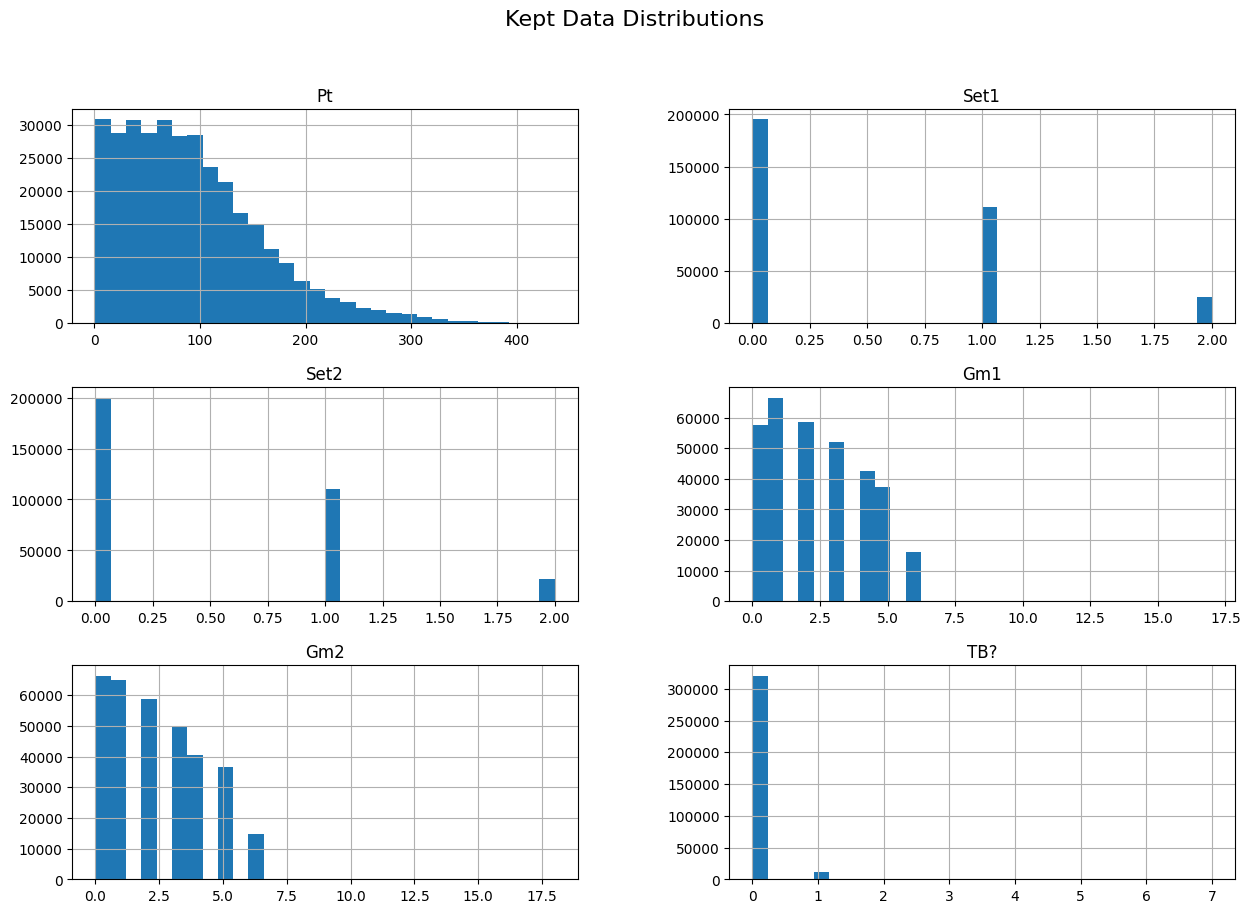

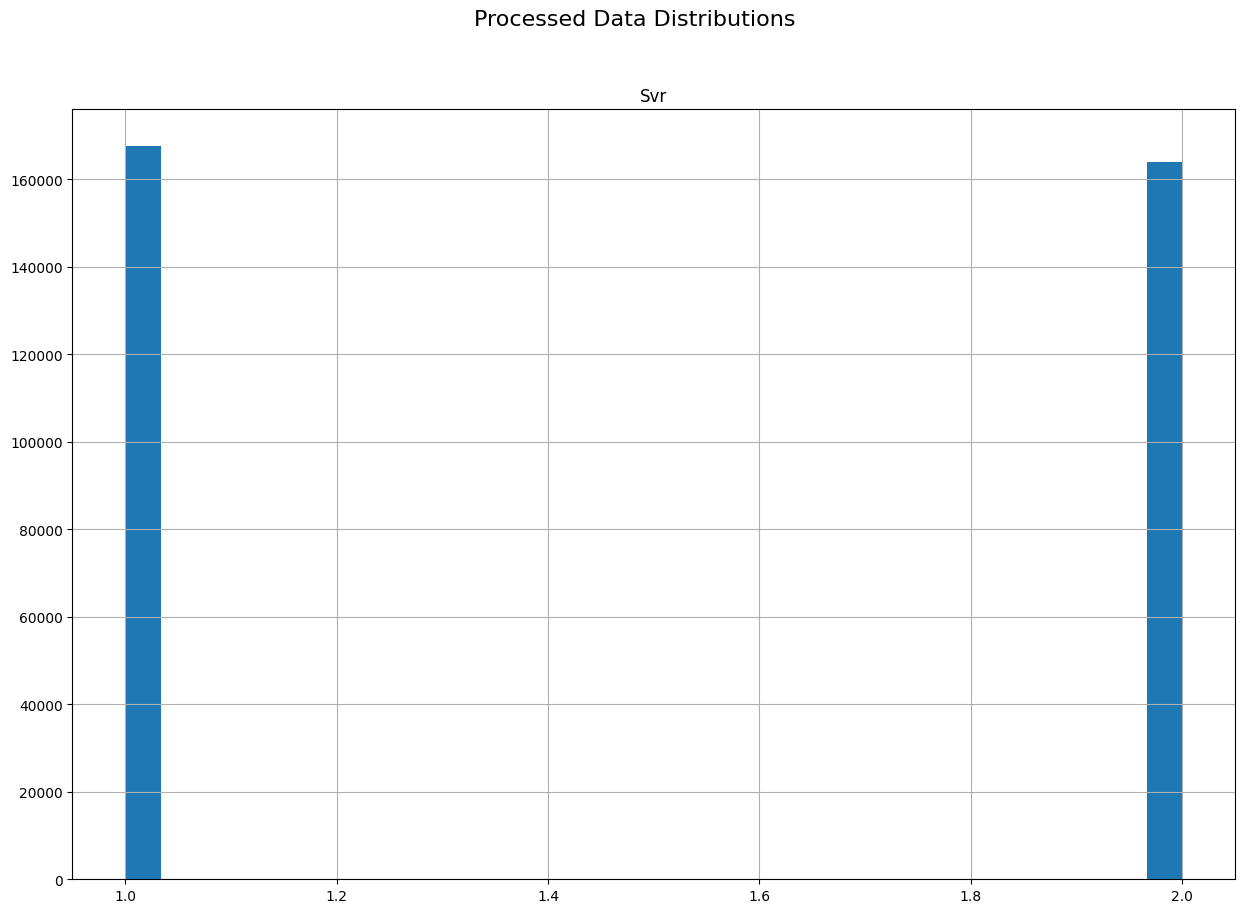

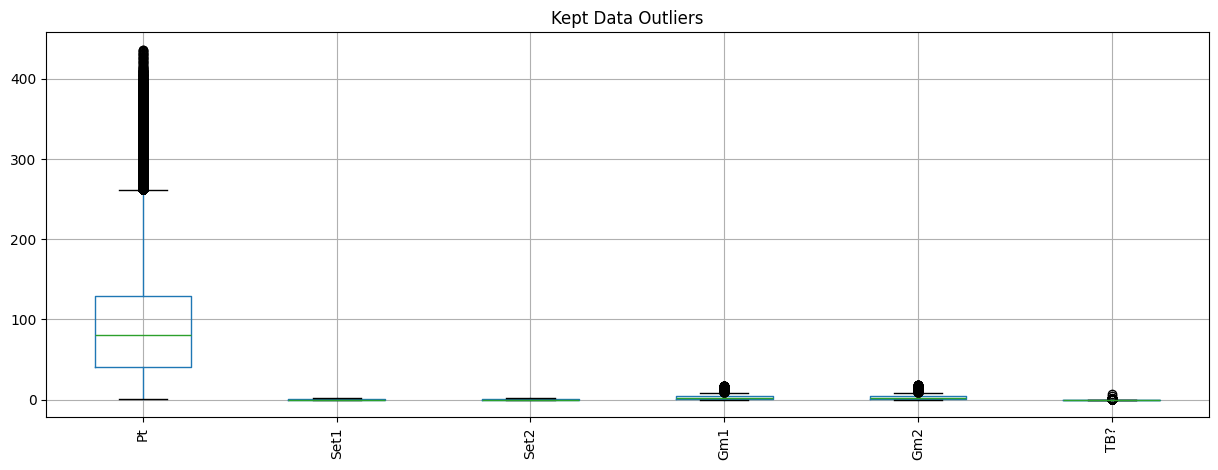

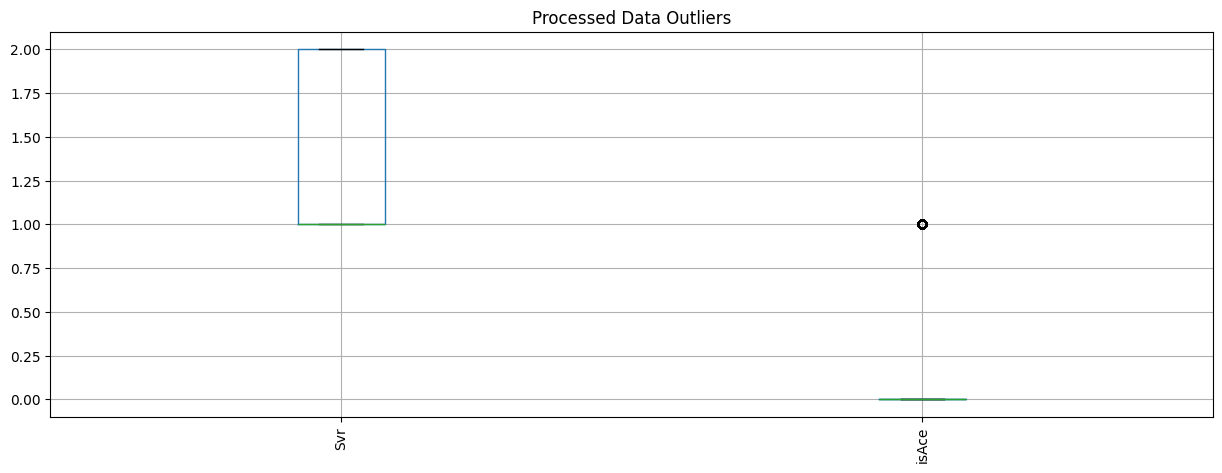


Kept Data Summary Statistics:
                  Pt           Set1           Set2            Gm1  \
count  331718.000000  331718.000000  331718.000000  331718.000000   
mean       92.435804       0.488367       0.462727       2.408525   
std        66.311026       0.635157       0.616833       1.812767   
min         1.000000       0.000000       0.000000       0.000000   
25%        41.000000       0.000000       0.000000       1.000000   
50%        81.000000       0.000000       0.000000       2.000000   
75%       129.000000       1.000000       1.000000       4.000000   
max       436.000000       2.000000       2.000000      17.000000   

                 Gm2            TB?  
count  331718.000000  331718.000000  
mean        2.313510       0.033109  
std         1.822026       0.179377  
min         0.000000       0.000000  
25%         1.000000       0.000000  
50%         2.000000       0.000000  
75%         4.000000       0.000000  
max        18.000000       7.000000  

Proc

In [ ]:
# Visualize distributions to identify skewness
processed_data.hist(bins=30, figsize=(15, 10))
plt.suptitle("Processed Data Distributions", fontsize=16)
plt.show()

# Visualize outliers using boxplots
plt.figure(figsize=(15, 5))
processed_data.boxplot()
plt.title("Kept Data Outliers")
plt.xticks(rotation=90)
plt.show()

print("\nProcessed Data Summary Statistics:")
print(processed_data.describe())